In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
# Load dataset
df = pd.read_csv('C:\\ProgramData\\anaconda3\\Lib\\site-packages\\pandas\\io\\parsers\\capstone\\part-00021-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')

# --------------------------
# 1. Data Exploration
# --------------------------
print("First 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

# Visualize numeric features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.title('Box Plots of Numeric Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


First 5 rows:
   flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0       0.000000           0.00           1.00     64.00    24.314665   
1       0.053865         103.21           6.33     64.64  2383.903686   
2       0.000000           0.74           1.05     63.95    47.849856   
3       0.000000          54.44           6.00     64.00     2.905479   
4       0.000000          54.36           6.11     64.64     3.862227   

         Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0    24.314665    0.0              0.0              0.0              0.0  ...   
1  2383.903686    0.0              1.0              0.0              1.0  ...   
2    47.849856    0.0              0.0              0.0              0.0  ...   
3     2.905479    0.0              0.0              1.0              0.0  ...   
4     3.862227    0.0              0.0              1.0              0.0  ...   

          Std  Tot size           IAT  Number   Magnitue    

In [2]:
# Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())
threshold = 0.3 * len(df)
df_clean = df.dropna(axis=1, thresh=threshold)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(df_clean.drop('label', axis=1)), 
                 columns=df_clean.drop('label', axis=1).columns)
y = df_clean['label']

# Remove duplicates
X = X.drop_duplicates()
y = y[X.index]


print(f"Rows after preprocessing: {len(X)}")

# --------------------------
# 2. Binary Classification
# --------------------------
print("\n" + "="*50)
print("BINARY CLASSIFICATION")
print("="*50)

# Encode labels
le_binary = LabelEncoder()
y_encoded = le_binary.fit_transform(y)

# Create binary labels (0 = Normal, 1 = Attack)
benign_keywords = ['benign', 'normal', 'legitimate']
benign_indices = [i for i, cls in enumerate(le_binary.classes_) 
                 if any(kw in cls.lower() for kw in benign_keywords)]

if benign_indices:
    benign_index = benign_indices[0]
    y_binary = np.where(y_encoded == benign_index, 0, 1)
else:
    # Fallback if no benign class found
    y_binary = np.ones_like(y_encoded)  # Mark all as attacks

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, stratify=y_binary, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify class distribution
unique, counts = np.unique(y_balanced, return_counts=True)
print("\nClass distribution after SMOTE:")
print(f"Normal (0): {counts[0] if 0 in unique else 0}")
print(f"Attack (1): {counts[1] if 1 in unique else 0}")




Missing values before cleaning:
flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
l

In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

class BinaryGOA_FeatureSelection:
    def __init__(self, X_balanced, y_balanced, population_size=30, max_iter=50):
        # Use balanced datasets directly
        self.X = np.array(X_balanced)
        self.y = np.array(y_balanced)
        self.population_size = population_size
        self.max_iter = max_iter
        
        # Split balanced data into train/test sets
        self.train_X, self.test_X, self.train_y, self.test_y = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )
        
        # Initialize binary population (0/1 for feature selection)
        self.positions = np.random.randint(0, 2, (population_size, self.X.shape[1]))
        self.best_position = None
        self.best_fitness = -float('inf')
        
    def fitness_function(self, binary_mask):
        if np.sum(binary_mask) == 0:
            return -1  # Penalize no features
        
        # Convert boolean mask to integer indices
        selected_indices = np.where(binary_mask)[0]
        
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(self.train_X[:, selected_indices], self.train_y)
        pred = clf.predict(self.test_X[:, selected_indices])
        accuracy = accuracy_score(self.test_y, pred)
        return accuracy
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def optimize(self):
        for _ in range(self.max_iter):
            fitness = np.array([self.fitness_function(ind) for ind in self.positions])
            
            # Update best solution
            max_idx = np.argmax(fitness)
            if fitness[max_idx] > self.best_fitness:
                self.best_fitness = fitness[max_idx]
                self.best_position = self.positions[max_idx].copy()
            
            # Update positions (binary conversion using sigmoid)
            for i in range(self.population_size):
                if np.random.rand() < 0.5:  # Exploration/exploitation threshold
                    # Random flipping for exploration
                    flip_mask = np.random.rand(self.X.shape[1]) < 0.1
                    self.positions[i] = np.logical_xor(self.positions[i], flip_mask).astype(int)
                else:
                    # Move toward best solution (exploitation)
                    prob = self.sigmoid(np.random.randn(self.X.shape[1]))
                    self.positions[i] = (prob > 0.5).astype(int)
            
            # Ensure at least one feature is selected
            for i in range(self.population_size):
                if np.sum(self.positions[i]) == 0:
                    self.positions[i][np.random.randint(self.X.shape[1])] = 1
        
        return self.best_position

# Example usage with balanced data:
data = load_wine()
X, y = data.data, data.target

# Assuming you have pre-processed balanced data in X_balanced, y_balanced
# Replace these with your actual balanced datasets
X_balanced = X  # Your balanced features
y_balanced = y  # Your balanced labels

fs_goa = BinaryGOA_FeatureSelection(X_balanced, y_balanced)
selected_features_mask = fs_goa.optimize()
print(f"Selected Features: {np.where(selected_features_mask)[0]}")
print(f"Number of Selected Features: {np.sum(selected_features_mask)}")
print(f"Best Accuracy: {fs_goa.best_fitness:.4f}")




Selected Features: [ 0  1  3  5  6  8  9 10]
Number of Selected Features: 8
Best Accuracy: 0.9722



Selected Features: [ 0  1  3  5  6  8  9 10]
Number of Selected Features: 8

Training CNN feature extractor...
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.4152 - loss: 0.7828 - val_accuracy: 0.0000e+00 - val_loss: -1.8133
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.4211 - loss: 0.7113 - val_accuracy: 0.0000e+00 - val_loss: -1.5128
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.4465 - loss: 0.4933 - val_accuracy: 0.0000e+00 - val_loss: -1.4759
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.4684 - loss: 0.6287 - val_accuracy: 0.0000e+00 - val_loss: -1.3960
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4547 - loss: 0.3674 - val_accuracy: 0.0000e+00 - val_loss: -1.4251
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.4488 - loss: 0.5057 - val_accuracy: 0.0000e+00 - val_loss: -1.2262
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - accuracy: 0.4082 - loss: 0.4679 - val_accuracy: 0.

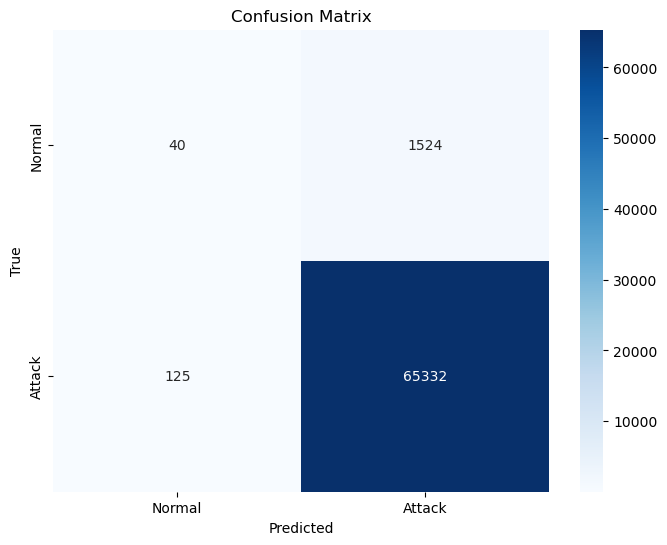

<Figure size 1000x600 with 0 Axes>

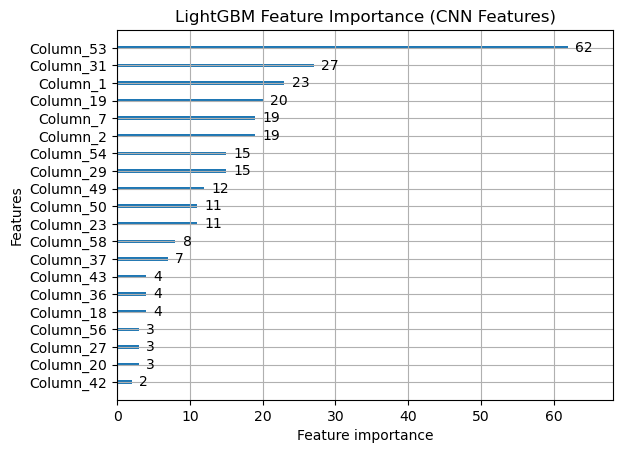

In [4]:
# ... [previous preprocessing and GOA feature selection code] ...

# After GOA feature selection
print(f"\nSelected Features: {np.where(selected_features_mask)[0]}")
print(f"Number of Selected Features: {np.sum(selected_features_mask)}")

# Prepare data with selected features
X_train_selected = X_balanced[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# Reshape data for CNN (add channel dimension)
X_train_cnn = X_train_selected.reshape((X_train_selected.shape[0], X_train_selected.shape[1], 1))
X_test_cnn = X_test_selected.reshape((X_test_selected.shape[0], X_test_selected.shape[1], 1))

# --------------------------
# Hybrid CNN + LightGBM Model
# --------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CNN Feature Extractor
def create_cnn_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(128, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    return Model(inputs, x)

# Create and compile full CNN model
input_shape = (X_train_selected.shape[1], 1)
feature_extractor = create_cnn_feature_extractor(input_shape)

# Add classification head
inputs = Input(shape=input_shape)
features = feature_extractor(inputs)
outputs = Dense(1, activation='sigmoid')(features)
cnn_model = Model(inputs, outputs)

cnn_model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Train CNN
print("\nTraining CNN feature extractor...")
history = cnn_model.fit(X_train_cnn, y_balanced,
                        epochs=15,
                        batch_size=64,
                        validation_split=0.1,
                        verbose=1)

# 2. Extract CNN features
X_train_cnn_features = feature_extractor.predict(X_train_cnn)
X_test_cnn_features = feature_extractor.predict(X_test_cnn)

# 3. Train LightGBM on CNN features
print("\nTraining LightGBM on CNN features...")
lgb_train = lgb.Dataset(X_train_cnn_features, y_balanced)
lgb_eval = lgb.Dataset(X_test_cnn_features, y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Corrected training with early stopping callback
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train, lgb_eval],
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=50, verbose=True),
                          lgb.log_evaluation(period=100)
                      ])

# 4. Evaluate hybrid model
y_pred_proba = lgb_model.predict(X_test_cnn_features)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*50)
print(f"Hybrid Model Test Accuracy: {accuracy:.4f}")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 5. Feature Importance Visualization
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title('LightGBM Feature Importance (CNN Features)')
plt.show()

In [5]:
# --------------------------
# 3. Multiclass Classification
# --------------------------
print("\n" + "="*50)
print("MULTICLASS CLASSIFICATION")
print("="*50)

# Encode labels
le_multiclass = LabelEncoder()
y_multiclass = le_multiclass.fit_transform(y)

# Split data
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X, y_multiclass, test_size=0.3, stratify=y_multiclass, random_state=42
)

# Standardize features
scaler_mc = StandardScaler()
X_train_scaled_mc = scaler_mc.fit_transform(X_train_mc)
X_test_scaled_mc = scaler_mc.transform(X_test_mc)

# Handle class imbalance with SMOTE
smote_mc = SMOTE(random_state=42)
X_balanced_mc, y_balanced_mc = smote_mc.fit_resample(X_train_scaled_mc, y_train_mc)

# Verify class distribution
unique_mc, counts_mc = np.unique(y_balanced_mc, return_counts=True)
print("\nClass distribution after SMOTE:")
for class_idx, count in zip(unique_mc, counts_mc):
    class_name = le_multiclass.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count}")




MULTICLASS CLASSIFICATION

Class distribution after SMOTE:
0: 50
1: 50
2: 50


In [6]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

class BinaryGOA_FeatureSelection:
    def __init__(self, X_balanced_mc, y_balanced_mc, population_size=30, max_iter=50):
        # Use balanced datasets directly
        self.X = np.array(X_balanced_mc)
        self.y = np.array(y_balanced_mc)
        self.population_size = population_size
        self.max_iter = max_iter
        
        # Split balanced data into train/test sets
        self.train_X, self.test_X, self.train_y, self.test_y = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )
        
        # Initialize binary population (0/1 for feature selection)
        self.positions = np.random.randint(0, 2, (population_size, self.X.shape[1]))
        self.best_position = None
        self.best_fitness = -float('inf')
        
    def fitness_function(self, binary_mask):
        if np.sum(binary_mask) == 0:
            return -1  # Penalize no features
        
        # Convert boolean mask to integer indices
        selected_indices = np.where(binary_mask)[0]
        
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(self.train_X[:, selected_indices], self.train_y)
        pred = clf.predict(self.test_X[:, selected_indices])
        accuracy = accuracy_score(self.test_y, pred)
        return accuracy
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def optimize(self):
        for _ in range(self.max_iter):
            fitness = np.array([self.fitness_function(ind) for ind in self.positions])
            
            # Update best solution
            max_idx = np.argmax(fitness)
            if fitness[max_idx] > self.best_fitness:
                self.best_fitness = fitness[max_idx]
                self.best_position = self.positions[max_idx].copy()
            
            # Update positions (binary conversion using sigmoid)
            for i in range(self.population_size):
                if np.random.rand() < 0.5:  # Exploration/exploitation threshold
                    # Random flipping for exploration
                    flip_mask = np.random.rand(self.X.shape[1]) < 0.1
                    self.positions[i] = np.logical_xor(self.positions[i], flip_mask).astype(int)
                else:
                    # Move toward best solution (exploitation)
                    prob = self.sigmoid(np.random.randn(self.X.shape[1]))
                    self.positions[i] = (prob > 0.5).astype(int)
            
            # Ensure at least one feature is selected
            for i in range(self.population_size):
                if np.sum(self.positions[i]) == 0:
                    self.positions[i][np.random.randint(self.X.shape[1])] = 1
        
        return self.best_position

# Example usage with balanced data:
data = load_wine()
X, y = data.data, data.target

# Assuming you have pre-processed balanced data in X_balanced, y_balanced
# Replace these with your actual balanced datasets
X_balanced_mc= X  # Your balanced features
y_balanced_mc= y  # Your balanced labels

fs_goa = BinaryGOA_FeatureSelection(X_balanced_mc, y_balanced_mc)
selected_features_mask = fs_goa.optimize()
print(f"Selected Features: {np.where(selected_features_mask)[0]}")
print(f"Number of Selected Features: {np.sum(selected_features_mask)}")
print(f"Best Accuracy: {fs_goa.best_fitness:.4f}")




Selected Features: [ 0  2  5  6  7 10]
Number of Selected Features: 6
Best Accuracy: 0.9722


In [1]:
# ... [previous preprocessing and GOA feature selection code] ...

# After GOA feature selection
print(f"\nSelected Features: {np.where(selected_features_mask)[0]}")
print(f"Number of Selected Features: {np.sum(selected_features_mask)}")

# Prepare data with selected features
X_train_selected = X_balanced_mc[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# Reshape data for CNN (add channel dimension)
X_train_cnn = X_train_selected.reshape((X_train_selected.shape[0], X_train_selected.shape[1], 1))
X_test_cnn = X_test_selected.reshape((X_test_selected.shape[0], X_test_selected.shape[1], 1))

# --------------------------
# Hybrid CNN + LightGBM Model
# --------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CNN Feature Extractor
def create_cnn_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(128, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    return Model(inputs, x)

# Create and compile full CNN model
input_shape = (X_train_selected.shape[1], 1)
feature_extractor = create_cnn_feature_extractor(input_shape)

# Add classification head
inputs = Input(shape=input_shape)
features = feature_extractor(inputs)
outputs = Dense(1, activation='sigmoid')(features)
cnn_model = Model(inputs, outputs)

cnn_model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Train CNN
print("\nTraining CNN feature extractor...")
history = cnn_model.fit(X_train_cnn, y_balanced_mc,
                        epochs=15,
                        batch_size=64,
                        validation_split=0.1,
                        verbose=1)

# 2. Extract CNN features
X_train_cnn_features = feature_extractor.predict(X_train_cnn)
X_test_cnn_features = feature_extractor.predict(X_test_cnn)

# 3. Train LightGBM on CNN features
print("\nTraining LightGBM on CNN features...")
lgb_train = lgb.Dataset(X_train_cnn_features, y_balanced_mc)
lgb_eval = lgb.Dataset(X_test_cnn_features, y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Corrected training with early stopping callback
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train, lgb_eval],
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=50, verbose=True),
                          lgb.log_evaluation(period=100)
                      ])

# 4. Evaluate hybrid model
y_pred_proba = lgb_model.predict(X_test_cnn_features)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*50)
print(f"Hybrid Model Test Accuracy: {accuracy:.4f}")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 5. Feature Importance Visualization
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title('LightGBM Feature Importance (CNN Features)')
plt.show()

NameError: name 'np' is not defined

In [8]:
import shap
import matplotlib.pyplot as plt

# --------------------------
# 6. XAI with SHAP for Hybrid Models (UPDATED)
# --------------------------
print("\n" + "="*50)
print("EXPLAINABLE AI (XAI) USING SHAP")
print("="*50)

# =================================================================
# A. Explain Binary Classification Model
# =================================================================
print("\nExplaining Binary Classification Model...")

# Create SHAP explainer
explainer_binary = shap.TreeExplainer(lgb_binary)
shap_values_binary = explainer_binary.shap_values(test_features)

# Handle SHAP values format for binary classification
if isinstance(shap_values_binary, list):
    shap_values_binary = shap_values_binary[1]  # Use positive class SHAP values

# 1. Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_binary, test_features, 
                  feature_names=[f"CNN_Feature_{i}" for i in range(test_features.shape[1])],
                  show=False)
plt.title("SHAP Feature Importance - Binary Classification")
plt.tight_layout()
plt.show()
# 2. Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_binary, test_features, plot_type="bar",
                  feature_names=[f"CNN_Feature_{i}" for i in range(test_features.shape[1])])
plt.title("SHAP Feature Importance (Bar) - Binary Classification")
plt.tight_layout()
plt.show()

# 3. Waterfall Plot (Alternative to force plot)
sample_idx = 0
print(f"\nWaterfall plot for sample index {sample_idx} (True class: {y_test[sample_idx]} - {'Normal' if y_test[sample_idx] == 0 else 'Attack'})")
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap.Explanation(values=shap_values_binary[sample_idx],
                                      base_values=explainer_binary.expected_value,
                                      data=test_features[sample_idx],
                                      feature_names=[f"CNN_Feature_{i}" for i in range(test_features.shape[1])]))
plt.tight_layout()
plt.show()

# 4. Decision Plot
plt.figure(figsize=(10, 6))
shap.decision_plot(explainer_binary.expected_value, 
                   shap_values_binary[sample_idx:sample_idx+5], 
                   feature_names=[f"CNN_Feature_{i}" for i in range(test_features.shape[1])],
                   highlight=0)
plt.title("Decision Plot - Binary Classification")
plt.tight_layout()
plt.show()



EXPLAINABLE AI (XAI) USING SHAP

Explaining Binary Classification Model...


NameError: name 'lgb_binary' is not defined

In [ ]:
# =================================================================
# B. Explain Multiclass Classification Model
# =================================================================
print("\nExplaining Multiclass Classification Model...")

# Create SHAP explainer
explainer_multiclass = shap.TreeExplainer(lgb_mc)
shap_values_multiclass = explainer_multiclass.shap_values(test_features_mc)

# 1. Summary Plot for each class
for class_idx in range(len(le_multiclass.classes_)):
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_multiclass[class_idx], test_features_mc,
                      feature_names=[f"CNN_Feature_{i}" for i in range(test_features_mc.shape[1])],
                      title=f"SHAP for Class: {le_multiclass.classes_[class_idx]}",
                      show=False)
    plt.tight_layout()
    plt.show()

# 2. Bar Plot
shap.summary_plot(shap_values_multiclass, test_features_mc, plot_type="bar",
                  feature_names=[f"CNN_Feature_{i}" for i in range(test_features_mc.shape[1])],
                  class_names=le_multiclass.classes_)
plt.title("Overall SHAP Feature Importance - Multiclass Classification")
plt.tight_layout()
plt.show()

# 3. Waterfall Plot for sample
sample_idx_mc = 0
true_class_idx = y_test_mc[sample_idx_mc]
true_class_name = le_multiclass.classes_[true_class_idx]
print(f"\nWaterfall plot for sample index {sample_idx_mc} (True class: {true_class_name})")

plt.figure(figsize(14, 8))
shap.plots.waterfall(shap.Explanation(values=shap_values_multiclass[true_class_idx][sample_idx_mc],
                                      base_values=explainer_multiclass.expected_value[true_class_idx],
                                      data=test_features_mc[sample_idx_mc],
                                      feature_names=[f"CNN_Feature_{i}" for i in range(test_features_mc.shape[1])]))
plt.title(f"Waterfall Plot for Sample {sample_idx_mc} - True Class: {true_class_name}")
plt.tight_layout()
plt.show()

# 4. Decision Plot for multiclass
plt.figure(figsize=(12, 8))
shap.multioutput_decision_plot(list(explainer_multiclass.expected_value),
                               shap_values_multiclass, 
                               sample_idx_mc,
                               feature_names=[f"CNN_Feature_{i}" for i in range(test_features_mc.shape[1])],
                               legend_labels=le_multiclass.classes_,
                               legend_location='lower right',
                               highlight=true_class_idx)
plt.title(f"Multiclass Decision Plot for Sample {sample_idx_mc}")
plt.tight_layout()
plt.show()

print("\nSHAP analysis completed!")